# Porous media segmentation based on image augmentation

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import warnings

from matplotlib.pyplot import imshow
from sklearn.utils import shuffle

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers
import tensorflow.keras as keras

from tensorflow.keras.layers import Input, BatchNormalization, Conv2D
from tensorflow.keras.layers import Dropout, Add, Activation, Concatenate, Permute
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras import layers

## Data processing

### Training set

In [71]:
train_x = np.load("train_x.npy")
train_y = np.load("train_y.npy")

val_x = np.load("val_x.npy")
val_y = np.load("val_y.npy")

test_x = np.load("test_x.npy")
test_y = np.load("test_y.npy")


## ResNet model

In [95]:
## Define U-net model
# n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[0]-1
input_layer = Input(shape=(train_x.shape[1], train_x.shape[2], train_x.shape[3]))
# Entry block
x = Conv2D(32, 3, strides=2, padding="same")(input_layer)
x = BatchNormalization()(x)
x = Activation("relu")(x)
previous_block_activation = x  

for filters in [64, 128, 256]:
    x = Activation("relu")(x)
    x = SeparableConv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = SeparableConv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(3, strides=2, padding="same")(x)
    x = Dropout(0.35)(x)
    residual = layers.Conv2D(filters, 1, strides=2, padding="same")(previous_block_activation)
    x = add([x, residual])  
    previous_block_activation = x  


for filters in [256, 128, 64, 32]:
    x = Activation("relu")(x)
    x = Conv2DTranspose(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2DTranspose(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(2)(x)
    x = Dropout(0.35)(x)
    residual = UpSampling2D(2)(previous_block_activation)
    residual = Conv2D(filters, 1, padding="same")(residual)
    x = add([x, residual])  
    previous_block_activation = x 
outputs = Conv2D(1,3, padding = "same", activation="linear")(x)
model = Model(input_layer,outputs)
model.summary()


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_63 (Conv2D)             (None, 128, 128, 32  320         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_105 (Batch  (None, 128, 128, 32  128        ['conv2d_63[0][0]']              
 Normalization)                 )                                                           

## Try different loss function

#### - binary cross entropy
#### - L1 loss
#### - sparse categorical crossentropy


#### 1. Pixel wise cross entropy

In [74]:
def loss_func(y_true, y_pred):
    loss = K.mean(K.abs(y_pred - y_true), axis=-1) + tf.keras.losses.BinaryCrossentropy(from_logits=True)(y_true, y_pred) 
 
    return loss


In [96]:
# scc = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.compat.v1.losses.Reduction.NONE)
model.compile("adam", loss=loss_func)
history1=model.fit(train_x, train_y, validation_data=(val_x,val_y), epochs=100, batch_size=16, shuffle=True)

Epoch 1/100
80/80 [==============================] - 14s 141ms/step - loss: 2.9810 - val_loss: 1.8596
Epoch 2/100
80/80 [==============================] - 10s 131ms/step - loss: 1.1954 - val_loss: 1.7414
Epoch 3/100
80/80 [==============================] - 11s 139ms/step - loss: 1.0297 - val_loss: 1.3437
Epoch 4/100
80/80 [==============================] - 11s 132ms/step - loss: 0.9472 - val_loss: 1.0748
Epoch 5/100
80/80 [==============================] - 11s 132ms/step - loss: 0.9178 - val_loss: 0.9760
Epoch 6/100
80/80 [==============================] - 11s 136ms/step - loss: 0.8697 - val_loss: 0.8274
Epoch 7/100
80/80 [==============================] - 11s 136ms/step - loss: 0.8580 - val_loss: 0.7787
Epoch 8/100
80/80 [==============================] - 10s 129ms/step - loss: 0.8484 - val_loss: 0.7640
Epoch 9/100
80/80 [==============================] - 11s 138ms/step - loss: 0.8132 - val_loss: 0.7504
Epoch 10/100
80/80 [==============================] - 11s 136ms/step - loss: 0.806

Text(0.5, 0, 'Epoch')

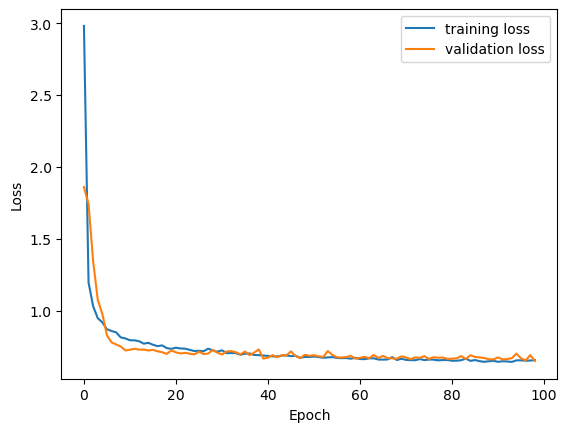

In [99]:
plt.figure()
outlier = 28
train_loss = history1.history['loss'][:outlier-1] + history1.history['loss'][outlier:]
val_loss = history1.history['val_loss'][:outlier-1] + history1.history['val_loss'][outlier:]
plt.plot(train_loss,label="training loss")
plt.plot(val_loss,label="validation loss")
#plt.ylim([0, 3])
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epoch")

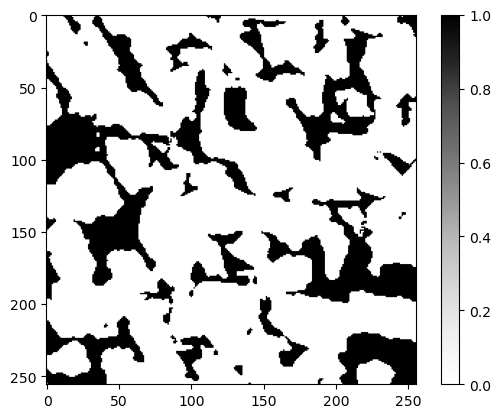

In [105]:
plt.imshow(test_y[12,:,:,0], cmap='Greys')
plt.colorbar()
plt.show()

In [100]:
testPred = model.predict(test_x)

16/16 [==============================] - 2s 86ms/step


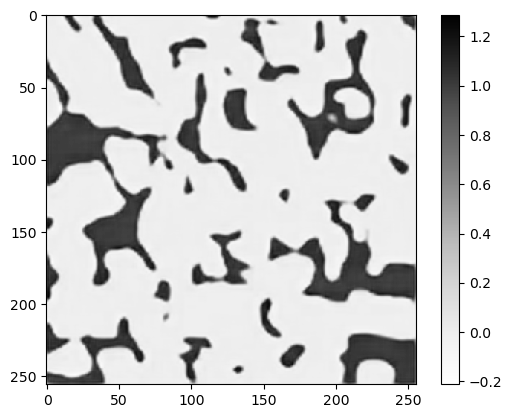

In [106]:
plt.imshow(testPred[12,:,:,0], cmap='Greys')
plt.colorbar()
plt.show()

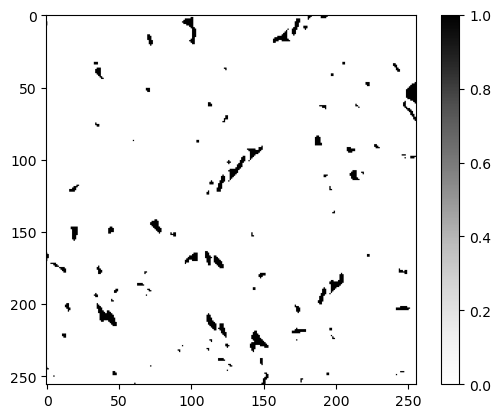

In [34]:
plt.imshow(test_y[7,:,:,0], cmap='Greys')
plt.colorbar()
plt.show()

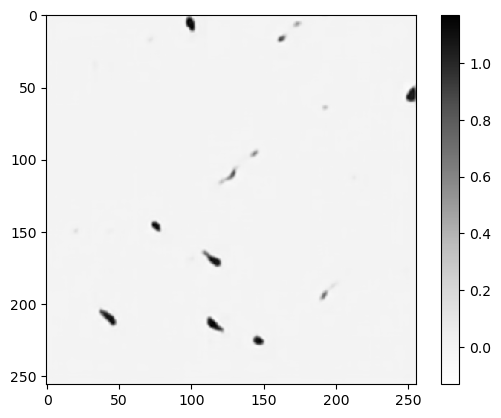

In [102]:
plt.imshow(testPred[7,:,:,0], cmap='Greys')
plt.colorbar()
plt.show()

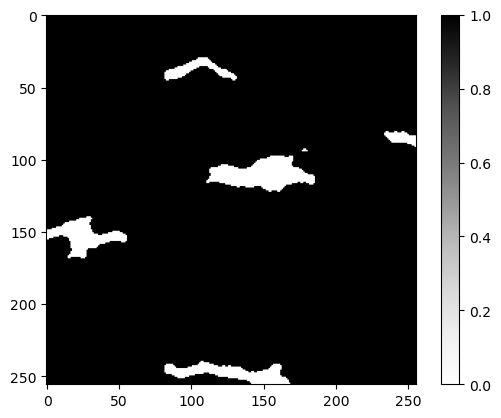

In [36]:
plt.imshow(test_y[15,:,:,0], cmap='Greys')
plt.colorbar()
plt.show()

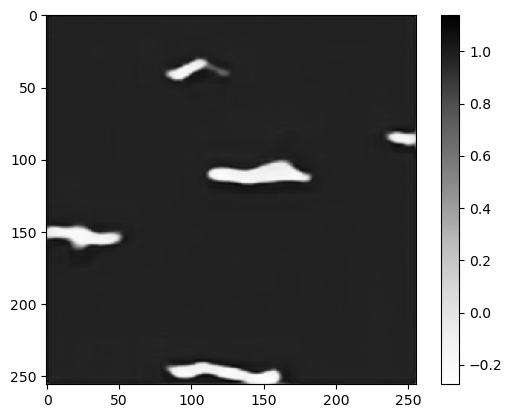

In [103]:
plt.imshow(testPred[15,:,:,0], cmap='Greys')
plt.colorbar()
plt.show()

In [104]:
def iou_coef(true, pred, smooth=1):
  intersection = K.sum(K.abs(true * pred))
  union = K.sum(true)+K.sum(pred)-intersection
  iou = K.mean((intersection + smooth) / (union + smooth))
  return iou

iou_acc = 0

for i in range(22):
    test_y = tf.cast(test_y, tf.double)
    testPred = tf.cast(testPred, tf.double)
    iou_acc += iou_coef(test_y[i,:,:,0], testPred[i,:,:,0], smooth=1)
    
iou_acc = iou_acc/(i+1)

print(iou_acc)

tf.Tensor(0.6619516823906851, shape=(), dtype=float64)
